In [6]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.integrate import odeint
import scipy.odr
import scipy
import statistics as st
import math
from matplotlib.pylab import *
from tabulate import tabulate


species=['ketene','ethanol','acetaldehyde','acetone','aceticacid','acetic anhydride','H2O','CO2','N2','H2']
ketene,ethanol,acetaldehyde,acetone,aceticacid,aceticanhydride,h2o,co2,n2,h2=range(10)
M=[42,46,44,58,60,102,18,44,28,2]
C=[2,2,2,3,2,4]
RRF=[0.279,0.279,0.415,0.27,0.56,0.46]

def pp(y,M,P):
    #partial pressure calculations
    Pi=(y/M)/sum(y/M)*P
    return Pi


# Ketene, ethanol, acetaldehyde, acetone, acetic acid, mesityl oxide, mesitylene, isophorone
# Importing data and producing area fraction
skiprowz=2
name='Tekstfiler/CuFe_75-25.txt'
A=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(1,2,3,4,5,6,))
t=(np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(0)))/60 # time in hours
T=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(7))+273.15 # temperatures in kelvin
H2f,N2f,AAf=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(8,9,10))
t=t-t[0]
gcat=[0.0102]*T.shape[0] #getting gcat as array

H2w=H2f/22400*M[h2] #ml/min til g/min
N2w=N2f/22400*M[n2]
AAw=AAf/1000*1.05   # ml/min -> 1050 mg/ml
WHSV=AAw/gcat*60 
Fin=H2w+N2w+AAw

N2wout=N2w/(H2w+N2w+AAw)
H2wout=H2w/(H2w+N2w+AAw)
AAwout=AAw/(H2w+N2w+AAw)


# convert to w%:
Afrac=A
for i in range(A.shape[1]):
    Afrac[:,i]=A[:,i]/sum(A[:,i])
Afrac=Afrac.transpose()
Wfrac=Afrac*RRF
Mfrac=Wfrac*C*12/M[0:6]
MH2O,MCO2=[np.zeros(A.shape[1])]*2

MH2O=Mfrac[:,0]+Mfrac[:,1]+Mfrac[:,2]+Mfrac[:,3]+1*Mfrac[:,5]
MCO2=Mfrac[:,3]


Mfrac=np.c_[Mfrac,MH2O,MCO2]
W=Mfrac
for i in range(Mfrac.shape[0]):
    W[i,:]=Mfrac[i,:]*M[0:8]/(sum(Mfrac[i,:]*M[0:8]))*AAwout[i]
W=np.c_[W,N2wout,H2wout]

w0=np.zeros([W.shape[0],W.shape[1]])
w0[:,aceticacid],w0[:,h2],w0[:,n2]=AAwout,H2wout,N2wout
Pout=np.zeros([W.shape[0],W.shape[1]])
Pin=np.zeros([W.shape[0],W.shape[1]])
for i in range(W.shape[0]):
    Pout[i,:]=pp(W[i,:],M,1)
    Pin[i,:]=pp(w0[i,:],M,1)

# calculate reaction rates
conversion=(w0[:,aceticacid]-W[:,aceticacid])/w0[:,aceticacid]*100 
#print('Conversion: ', conversion)
r=np.zeros([W.shape[0],W.shape[1]])
for i in range(r.shape[0]):
    r[i,:]=W[i,:]*Fin[i]/M/gcat[i]*10**6 #micromol/gcat/h
rt=r/10**6/3600 # mol/gcat/s

def arrh_time(T,t,r):
    n = T.size
    y = np.log(r)
    X = np.c_[np.ones(n), 1 / T, t]
    p=X.shape[1]   # number of parameters
    b,res,rank,sv=linalg.lstsq(X,y)  # least squares 
    yhat=np.dot(X, b)
    eps=y-yhat
    SSE = np.dot(eps,eps)  # e.T*e
    MSE =SSE/(n-p)   # alternative MSE = np.var(eps,ddof=p)
    cov= linalg.inv( np.dot(X.T,X) )*MSE
    se_b=np.sqrt(np.diag(cov))
    ymean = np.average(y)
    SST = ((y-ymean)**2).sum()
    SSR = SST - SSE 
    R2 = 1-SSE/SST
    R2_adj = 1-(SSE/(n-p))/(SST/(n-1))
    np.set_printoptions(precision=3)
    b[0]=np.exp(b[0]) # e^ln r0
    b[1]=-b[1]*8.314/1000 # Ea, units converted to kJ/mol
    tm=stats.t.isf(0.05/2.0,n-p)  # 95% confidence interval fence
    seb=np.sqrt(np.diag(cov))*tm
    q=b
    sig=(b/se_b)/stats.t.ppf(0.975,n-p)
    #T,t,Pout[:,aceticacid],Pout[:,h2],Pout[:,h2o]
    dataa=[[0]*3 for i in range(len(q))]
    pparameter=['A','Ea','kd']

    for i in range(len(pparameter)):
        dataa[i]=[pparameter[i],q[i],sig[i]]

    print(tabulate(dataa, headers=['Parameter','beta','Significant']))

    b=np.array(b)
    print("Adjusted R-squared: ", R2_adj)

    plt.plot(t,y,label='measured', color='lightsteelblue', marker='*', linestyle='None')
    plt.plot(t,yhat,label='modeled', color='midnightblue')
    plt.ylabel("ln r")
    plt.xlabel("Time")
    plt.legend(frameon=False)

    print('b: ', b)

    return b,yhat

#arrh_time(T,t, rt[:,acetone])





Conversion:  [27.947 28.701  9.945  9.488 10.663  9.361 10.187  9.436  9.41   8.974
  9.973  9.226  9.638  8.816  9.151  5.685  9.4    8.761  9.569  8.982
  8.365 99.897  8.886  9.05   9.094  8.565  8.893  8.543  8.464  8.237
  8.461  8.249  8.751  7.95   8.995  8.098  8.774  8.368  8.548  8.568
  8.422  8.836  9.718 11.744 12.303 12.605 12.586 12.095 12.868 11.674
 12.997 12.556 12.72  12.346 12.084 13.179 12.257 13.699 12.379 11.753
 12.44  12.79  11.852 12.66  11.931 13.375 12.472 99.908 11.798 12.837
 11.818 13.053 12.179 13.31  11.968 14.116 11.309 13.846 11.478 13.337
 11.828 12.239 11.895 11.969 17.696 15.083 16.616 16.714 16.955 17.215
 17.417 17.142 16.186 16.453 16.616 17.13  16.088 18.053 16.61  16.604
 16.218 15.198 17.085 17.202 17.456 17.226 17.338 16.337 17.345 16.449
 16.278 15.907 19.148 16.514 16.146 15.635 18.144 16.461 18.732 17.207
 17.725 16.525 18.853 15.669 20.231 18.623 24.104 23.86  25.844 24.147
 26.887 24.211 24.749 24.287 27.565 22.393 26.734 22.672 24.818 

Filtreringen:

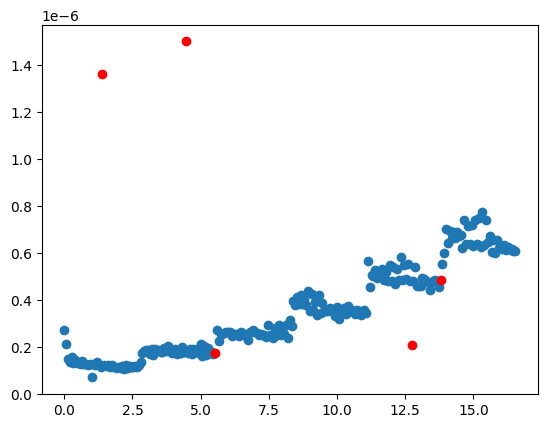

In [7]:
r_T=rt[:,acetone]

unique_temperatures = np.unique(T)

T_list = []
t_list = []
r_T_list = []
IDX_list = [] 

for temp in unique_temperatures:
    indices = np.where(T == temp)[0]

    T_temp = T[indices]
    t_temp = t[indices]
    r_T_temp = r_T[indices]

    mean_rt_acetone = np.mean(r_T_temp)
    std_dev = np.std(r_T_temp)

    lower_threshold = mean_rt_acetone - 3 * std_dev
    upper_threshold = mean_rt_acetone + 3 * std_dev
    
    outlier_indices = (r_T_temp < lower_threshold) | (r_T_temp > upper_threshold)
    #print("Outlier Indices:", outlier_indices)

    T_list.append(T_temp)
    t_list.append(t_temp)
    r_T_list.append(r_T_temp)
    IDX_list.append(outlier_indices)


for t, r_T, idx in zip(t_list, r_T_list, IDX_list):

    plt.scatter(t[idx], r_T[idx], color="red")
    plt.scatter(t[~idx], r_T[~idx], color="tab:blue")

plt.show()

filtered_T_list = []
filtered_t_list = []
filtered_r_T_list = []

for T_temp, t_temp, r_T_temp, outlier_indices in zip(T_list, t_list, r_T_list, IDX_list):
    filtered_T_temp = T_temp[~outlier_indices]
    filtered_t_temp = t_temp[~outlier_indices]
    filtered_r_T_temp = r_T_temp[~outlier_indices]

    filtered_T_list.append(filtered_T_temp)
    filtered_t_list.append(filtered_t_temp)
    filtered_r_T_list.append(filtered_r_T_temp)

r_T_filtered = np.concatenate(filtered_r_T_list)
T_filtered = np.concatenate(filtered_T_list)
t_filtered = np.concatenate(filtered_t_list)




Parameter             beta    Significant
-----------  -------------  -------------
A            40263.8        14133.9
Ea             125.958          0.0775905
kd              -0.0338683     -2.08798
Adjusted R-squared:  0.9677629396501792
b:  [ 4.026e+04  1.260e+02 -3.387e-02]


/var/folders/4w/bkdv3bx904ncw2sp853y5wt40000gn/T/ipykernel_63192/2220388541.py:88: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b,res,rank,sv=linalg.lstsq(X,y)  # least squares


(array([ 4.026e+04,  1.260e+02, -3.387e-02]),
 array([-15.83 , -15.832, -15.834, -15.837, -15.839, -15.841, -15.843,
        -15.846, -15.848, -15.85 , -15.852, -15.855, -15.857, -15.859,
        -15.861, -15.864, -15.866, -15.868, -15.871, -15.873, -15.875,
        -15.88 , -15.882, -15.884, -15.886, -15.889, -15.891, -15.893,
        -15.895, -15.898, -15.9  , -15.902, -15.904, -15.907, -15.909,
        -15.911, -15.913, -15.916, -15.918, -15.92 , -15.922, -15.471,
        -15.474, -15.476, -15.478, -15.48 , -15.483, -15.485, -15.487,
        -15.489, -15.492, -15.494, -15.496, -15.499, -15.501, -15.503,
        -15.505, -15.508, -15.51 , -15.512, -15.514, -15.517, -15.519,
        -15.521, -15.523, -15.526, -15.53 , -15.532, -15.535, -15.537,
        -15.539, -15.541, -15.544, -15.546, -15.548, -15.55 , -15.553,
        -15.555, -15.557, -15.559, -15.562, -15.128, -15.131, -15.133,
        -15.135, -15.137, -15.14 , -15.142, -15.144, -15.146, -15.149,
        -15.151, -15.153, -15.1

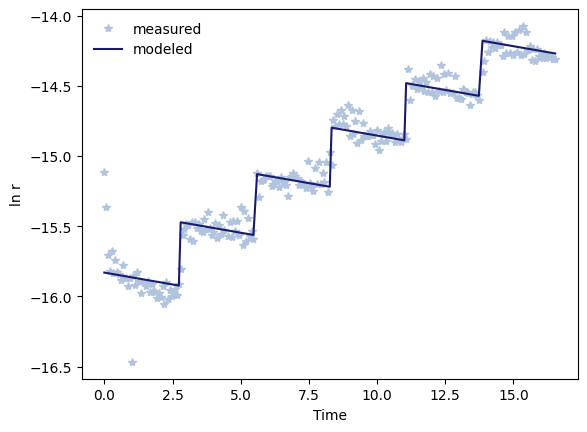

In [8]:
arrh_time(T_filtered,t_filtered,r_T_filtered)

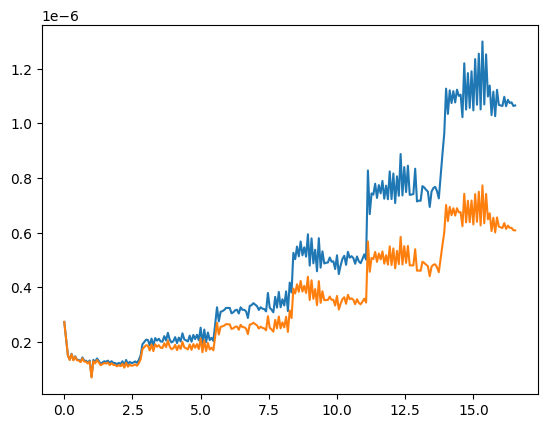

In [9]:
kd=-0.0338683
at=np.exp(kd*t)
filtered_at=np.exp(kd*t_filtered)


plt.plot(t_filtered,r_T_filtered/filtered_at)
plt.plot(t_filtered,r_T_filtered)

In [10]:
h = 6.62607015e-34  # Js
kB = 1.380649e-23   # J/K
R = 8.314           # J/mol

def arrh_time_dS(T,t,r):
    n = T.size
    y = np.log(r/T)
    X = np.c_[np.ones(n), 1 / T, t]
    p=X.shape[1]   # number of parameters
    b,res,rank,sv=linalg.lstsq(X,y)  # least squares 
    yhat=np.dot(X, b)
    eps=y-yhat
    SSE = np.dot(eps,eps)  # e.T*e
    MSE =SSE/(n-p)   # alternative MSE = np.var(eps,ddof=p)
    cov= linalg.inv( np.dot(X.T,X) )*MSE
    se_b=np.sqrt(np.diag(cov))
    ymean = np.average(y)
    SST = ((y-ymean)**2).sum()
    SSR = SST - SSE 
    R2 = 1-SSE/SST
    R2_adj = 1-(SSE/(n-p))/(SST/(n-1))
    np.set_printoptions(precision=3)

    b[0]=(b[0]-np.log(kB/h))*R
    b[1]=-b[1]*R/1000 # kJ/mol

   
    tm=stats.t.isf(0.05/2.0,n-p)  # 95% confidence interval fence
    seb=np.sqrt(np.diag(cov))*tm
    q=b
    sig=(b/se_b)/stats.t.ppf(0.975,n-p)
    #T,t,Pout[:,aceticacid],Pout[:,h2],Pout[:,h2o]
    dataa=[[0]*3 for i in range(len(q))]
    pparameter=['dS','dH','kd']

    for i in range(len(pparameter)):
        dataa[i]=[pparameter[i],q[i],sig[i]]

    print(tabulate(dataa, headers=['Parameter','beta','Significant']))

    b=np.array(b)
    print("Adjusted R-squared: ", R2_adj)

    """plt.plot(t,y,label='measured', color='lightsteelblue')
    plt.plot(t,yhat,label='modeled', color='midnightblue')
    plt.ylabel("ln r/T")
    plt.xlabel("Time")
    plt.legend(frameon=False)"""

    print('b: ', b)

    return b,yhat

arrh_time_dS(T_filtered,t_filtered,r_T_filtered)


Parameter            beta    Significant
-----------  ------------  -------------
dS           -170.764        -59.9247
dH            121.041          0.0745376
kd             -0.0339287     -2.09103
Adjusted R-squared:  0.9643476166630498
b:  [-1.708e+02  1.210e+02 -3.393e-02]


/var/folders/4w/bkdv3bx904ncw2sp853y5wt40000gn/T/ipykernel_63192/1153772748.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b,res,rank,sv=linalg.lstsq(X,y)  # least squares


(array([-1.708e+02,  1.210e+02, -3.393e-02]),
 array([-22.18 , -22.183, -22.185, -22.187, -22.19 , -22.192, -22.194,
        -22.196, -22.199, -22.201, -22.203, -22.205, -22.208, -22.21 ,
        -22.212, -22.214, -22.217, -22.219, -22.221, -22.223, -22.226,
        -22.23 , -22.233, -22.235, -22.237, -22.239, -22.242, -22.244,
        -22.246, -22.248, -22.251, -22.253, -22.255, -22.257, -22.26 ,
        -22.262, -22.264, -22.266, -22.269, -22.271, -22.273, -21.84 ,
        -21.842, -21.844, -21.847, -21.849, -21.851, -21.853, -21.856,
        -21.858, -21.86 , -21.863, -21.865, -21.867, -21.869, -21.872,
        -21.874, -21.876, -21.878, -21.881, -21.883, -21.885, -21.887,
        -21.89 , -21.892, -21.894, -21.899, -21.901, -21.903, -21.905,
        -21.908, -21.91 , -21.912, -21.915, -21.917, -21.919, -21.921,
        -21.924, -21.926, -21.928, -21.93 , -21.514, -21.516, -21.519,
        -21.521, -21.523, -21.525, -21.528, -21.53 , -21.532, -21.534,
        -21.537, -21.539, -21.5